In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import catboost as cat
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

color_pal = sns.color_palette()

In [6]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [7]:
test_data = pd.read_parquet(Path("data") / "test.parquet")

In [8]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [9]:
data["date"] = pd.to_datetime(data["date"])

In [10]:
data = data.set_index("date")

In [11]:
test_data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
56474,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 05:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56477,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.098612
56480,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 07:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56483,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2021-08-10 09:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
56486,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 10:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147


In [12]:
test_data["date"] = pd.to_datetime(test_data["date"])
test_data = test_data.set_index("date")

In [13]:
df = data[["counter_name", "log_bike_count"]]

In [14]:
df.head()

,counter_name,log_bike_count
date,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,0.000000
2020-09-01 03:00:00,28 boulevard Diderot E-O,0.693147
2020-09-01 04:00:00,28 boulevard Diderot E-O,0.000000
2020-09-01 15:00:00,28 boulevard Diderot E-O,1.609438
2020-09-01 18:00:00,28 boulevard Diderot E-O,2.302585


In [15]:
selected_counter_name = "Totem 73 boulevard de Sébastopol S-N"
train = df[df["counter_name"] == selected_counter_name]

In [16]:
# train.drop("counter_name", axis=1, inplace=True)

In [17]:
test = test_data[["counter_name", "log_bike_count"]]
test = test[test["counter_name"] == selected_counter_name]

In [18]:
# test.drop("counter_name", axis=1, inplace=True)

In [19]:
train.head()

,counter_name,log_bike_count
date,,
2020-09-01 03:00:00,Totem 73 boulevard de Sébastopol S-N,2.302585
2020-09-01 05:00:00,Totem 73 boulevard de Sébastopol S-N,5.298317
2020-09-01 08:00:00,Totem 73 boulevard de Sébastopol S-N,5.774552
2020-09-01 10:00:00,Totem 73 boulevard de Sébastopol S-N,5.857933
2020-09-01 17:00:00,Totem 73 boulevard de Sébastopol S-N,7.041412


In [20]:
test.head()

,counter_name,log_bike_count
date,,
2021-08-10 02:00:00,Totem 73 boulevard de Sébastopol S-N,2.397895
2021-08-10 03:00:00,Totem 73 boulevard de Sébastopol S-N,2.302585
2021-08-10 04:00:00,Totem 73 boulevard de Sébastopol S-N,3.332205
2021-08-10 05:00:00,Totem 73 boulevard de Sébastopol S-N,3.970292
2021-08-10 06:00:00,Totem 73 boulevard de Sébastopol S-N,5.003946


In [185]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

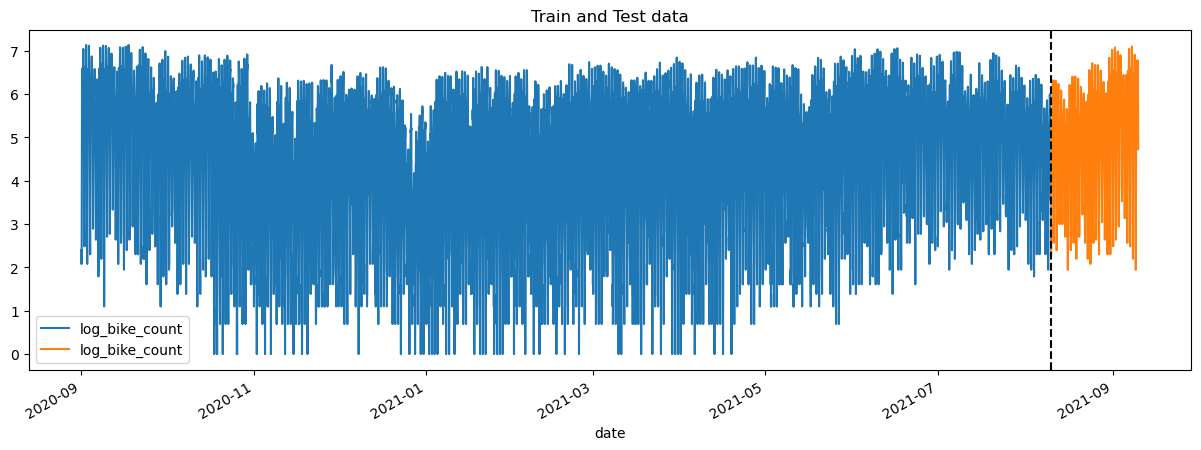

In [186]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Train and Test data")
test.plot(ax=ax, label="Testing Set")
ax.axvline("2021-08-10 02:00:00", color="black", ls="--")
ax.legend
plt.show()

<AxesSubplot: xlabel='date'>

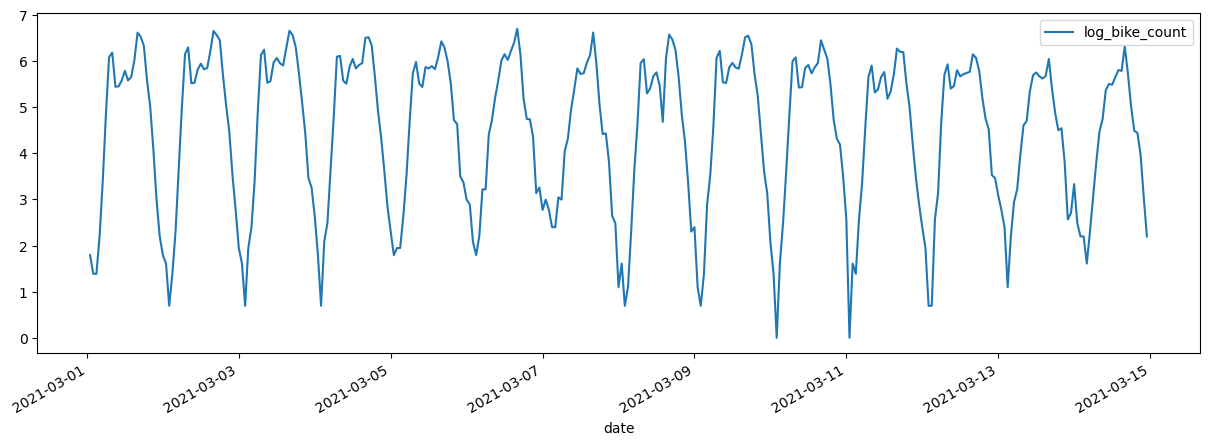

In [187]:
train.loc[(train.index > "2021-03-01") & (train.index < "2021-03-15")].plot(
    figsize=(15, 5)
)

<AxesSubplot: xlabel='date'>

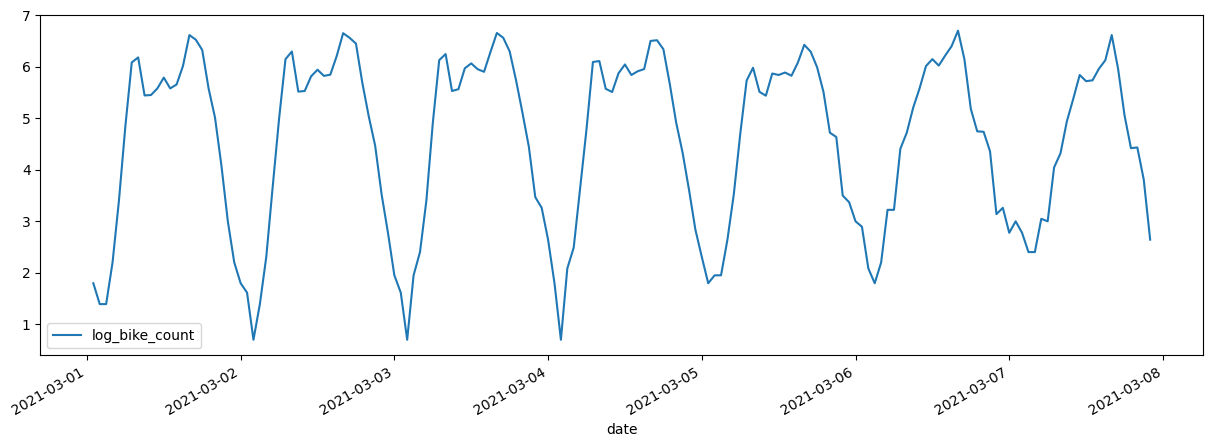

In [188]:
train.loc[
    (train.index > "2021-03-01 00:00:00") & (train.index < "2021-03-07 23:00:00")
].plot(figsize=(15, 5))

In [21]:
# Feature creation
def create_features(train):
    """
    Create time series features based on timeseries index
    """
    train["hour"] = train.index.hour
    train["dayofweek"] = train.index.dayofweek
    train["quarter"] = train.index.quarter
    train["month"] = train.index.month
    train["dayofyear"] = train.index.dayofyear
    return train

In [22]:
data = create_features(data)

In [23]:
train = create_features(train)
test = create_features(test)

C:\Users\ameya\AppData\Local\Temp\ipykernel_28600\1206218847.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["hour"] = train.index.hour
C:\Users\ameya\AppData\Local\Temp\ipykernel_28600\1206218847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["dayofweek"] = train.index.dayofweek
C:\Users\ameya\AppData\Local\Temp\ipykernel_28600\1206218847.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [24]:
train.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear
date,,,,,,,
2020-09-01 03:00:00,Totem 73 boulevard de Sébastopol S-N,2.302585,3,1,3,9,245
2020-09-01 05:00:00,Totem 73 boulevard de Sébastopol S-N,5.298317,5,1,3,9,245
2020-09-01 08:00:00,Totem 73 boulevard de Sébastopol S-N,5.774552,8,1,3,9,245
2020-09-01 10:00:00,Totem 73 boulevard de Sébastopol S-N,5.857933,10,1,3,9,245
2020-09-01 17:00:00,Totem 73 boulevard de Sébastopol S-N,7.041412,17,1,3,9,245


In [25]:
test.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear
date,,,,,,,
2021-08-10 02:00:00,Totem 73 boulevard de Sébastopol S-N,2.397895,2,1,3,8,222
2021-08-10 03:00:00,Totem 73 boulevard de Sébastopol S-N,2.302585,3,1,3,8,222
2021-08-10 04:00:00,Totem 73 boulevard de Sébastopol S-N,3.332205,4,1,3,8,222
2021-08-10 05:00:00,Totem 73 boulevard de Sébastopol S-N,3.970292,5,1,3,8,222
2021-08-10 06:00:00,Totem 73 boulevard de Sébastopol S-N,5.003946,6,1,3,8,222


Visualize our Feature/Target Relationship

Text(0.5, 1.0, 'Bike Counts by Hour')

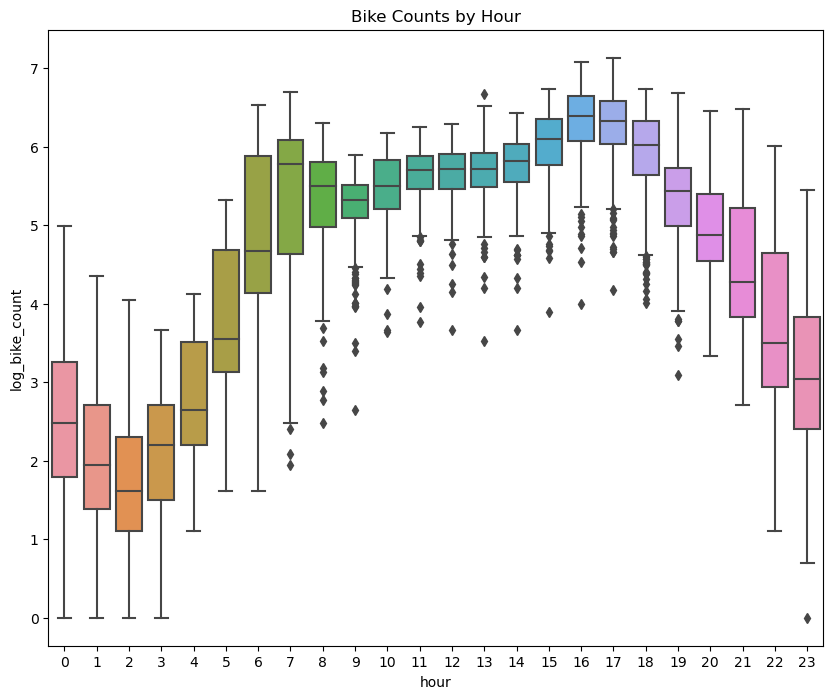

In [193]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x="hour", y="log_bike_count")
ax.set_title("Bike Counts by Hour")

Text(0.5, 1.0, 'Test Bike Counts by Hour')

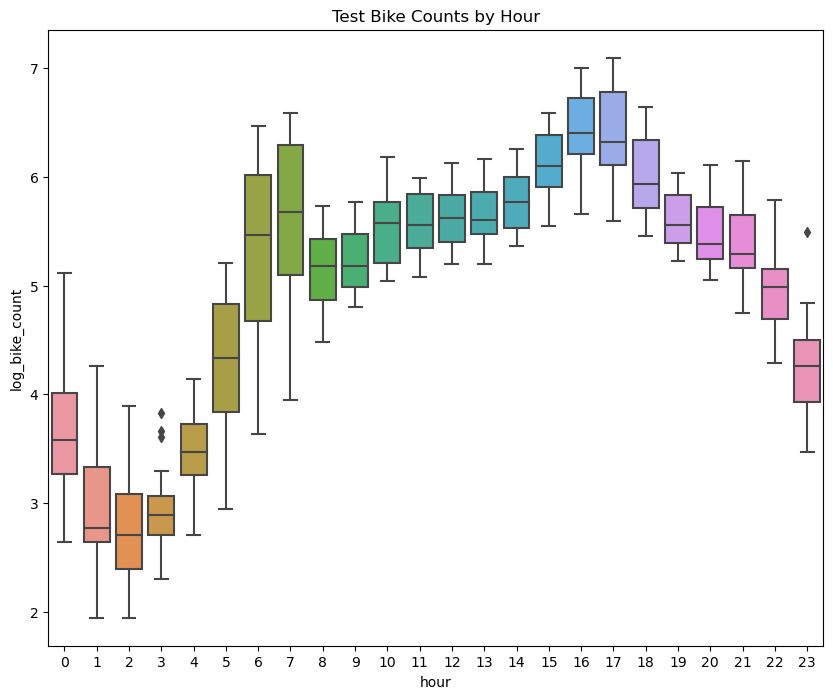

In [194]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=test, x="hour", y="log_bike_count")
ax.set_title("Test Bike Counts by Hour")

Text(0.5, 1.0, 'Bike Counts by Months')

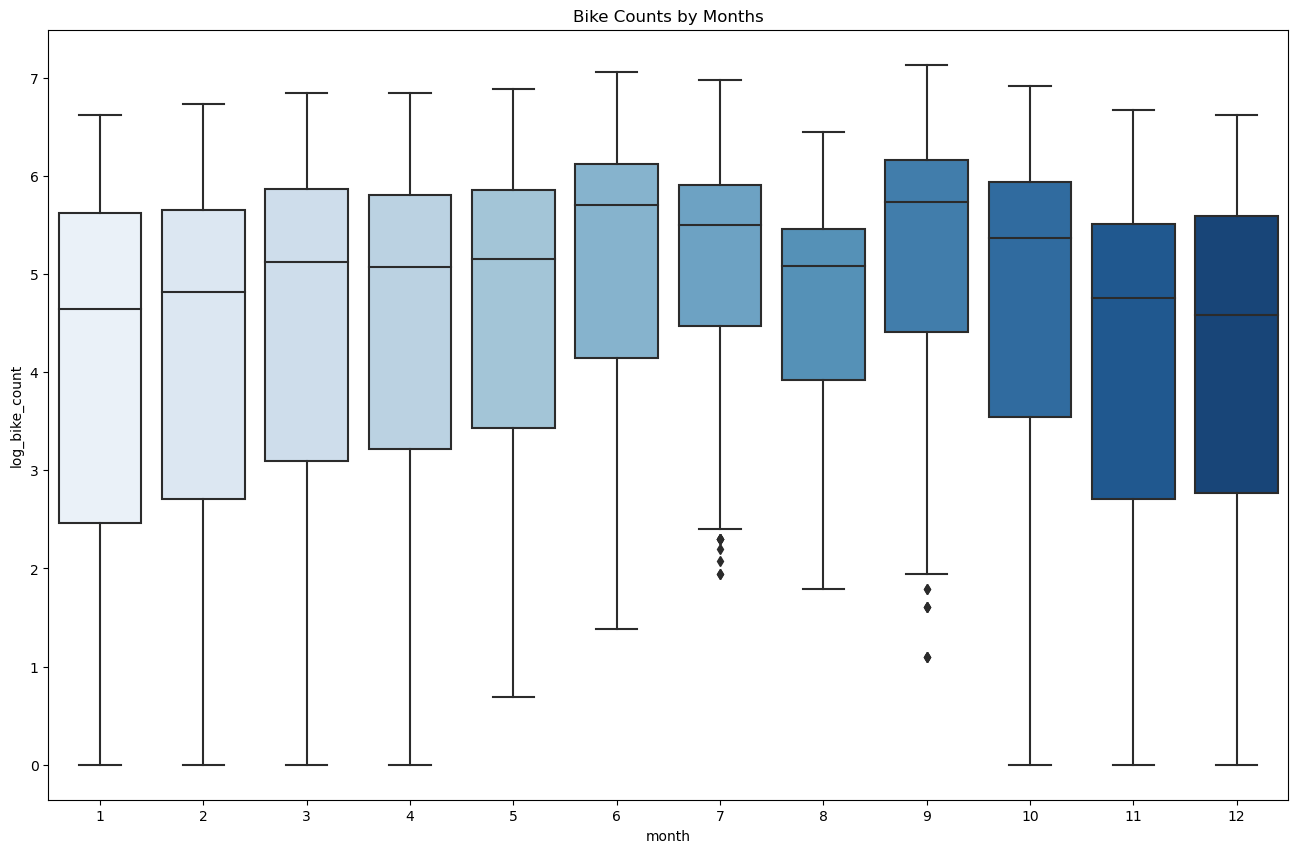

In [195]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=train, x="month", y="log_bike_count", palette="Blues")
ax.set_title("Bike Counts by Months")

Text(0.5, 1.0, 'Test Bike Counts by Months')

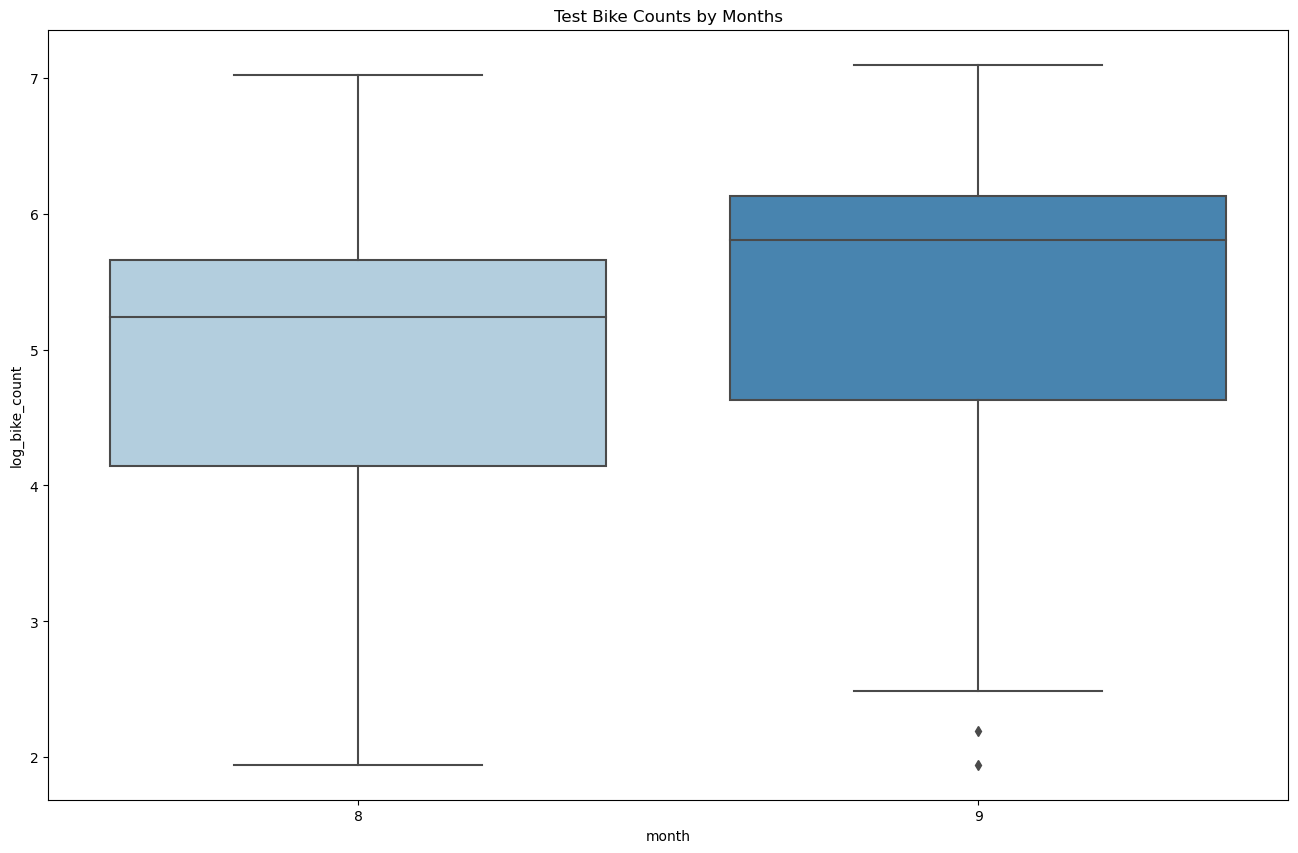

In [196]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=test, x="month", y="log_bike_count", palette="Blues")
ax.set_title("Test Bike Counts by Months")

Create our Model

In [26]:
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, enable_categorical=True)

In [27]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)

In [28]:
train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear'],
      dtype='object')

In [29]:
features = ["counter_name", "hour", "dayofweek",
            "quarter", "month", "dayofyear"]
target = ["log_bike_count"]
cat_feature = ['counter_name']

In [30]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [31]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.09852	validation_1-rmse:3.27608
[10]	validation_0-rmse:0.34028	validation_1-rmse:0.27688
[20]	validation_0-rmse:0.27509	validation_1-rmse:0.24177
[28]	validation_0-rmse:0.25464	validation_1-rmse:0.24931


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [32]:
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.070895
0:	learn: 1.5315400	test: 1.5315400	test1: 1.1672000	best: 1.1672000 (0)	total: 111ms	remaining: 1m 50s
10:	learn: 0.9476872	test: 0.9476872	test1: 0.6740277	best: 0.6740277 (10)	total: 137ms	remaining: 12.4s
20:	learn: 0.6832970	test: 0.6832970	test1: 0.4826485	best: 0.4826485 (20)	total: 162ms	remaining: 7.56s
30:	learn: 0.5651642	test: 0.5651642	test1: 0.4204533	best: 0.4204533 (30)	total: 185ms	remaining: 5.78s
40:	learn: 0.5086398	test: 0.5086398	test1: 0.4090229	best: 0.4090229 (40)	total: 209ms	remaining: 4.88s
50:	learn: 0.4772083	test: 0.4772083	test1: 0.3963182	best: 0.3963182 (50)	total: 232ms	remaining: 4.32s
60:	learn: 0.4562971	test: 0.4562971	test1: 0.3879613	best: 0.3879613 (60)	total: 256ms	remaining: 3.95s
70:	learn: 0.4412843	test: 0.4412843	test1: 0.3803847	best: 0.3803847 (70)	total: 280ms	remaining: 3.66s
80:	learn: 0.4279704	test: 0.4279704	test1: 0.3546728	best: 0.3546728 (80)	total: 303ms	remaining: 3.43s
90:	learn: 0.4169020	test:

In [37]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

XGB Train: 0.2824743125225122
CAT Train: 0.32088296890375584


In [58]:
y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

XGB Test: 0.23827569037243393
CAT Test: 0.25061219711487115


In [211]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

<AxesSubplot: title={'center': 'Feature Importances'}>

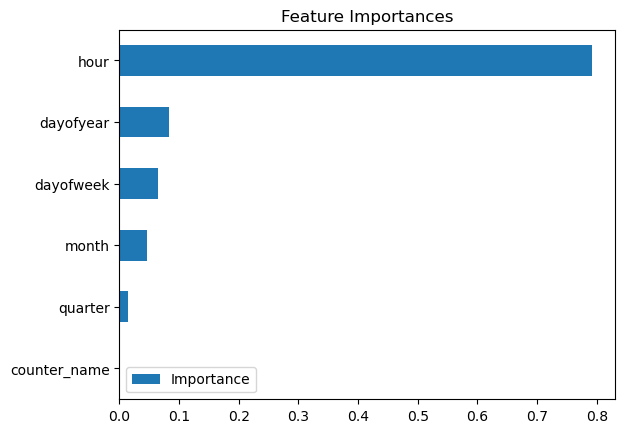

In [212]:
fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

# Forecast on Test

In [213]:
test["prediction"] = reg.predict(X_test)

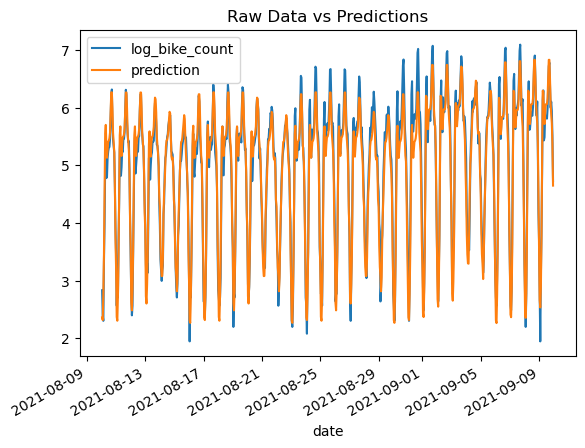

In [214]:
ax = test[["log_bike_count"]].plot()
test["prediction"].plot(ax=ax)
plt.legend()
ax.set_title("Raw Data vs Predictions")
plt.show()

<AxesSubplot: xlabel='date'>

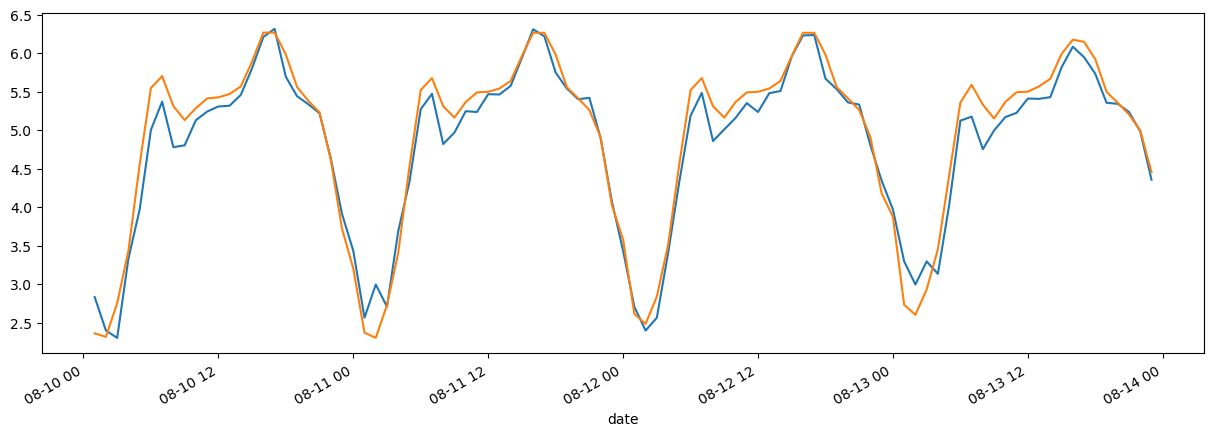

In [215]:
test.loc[(test.index > "2021-08-7") & (test.index < "2021-08-14")][
    "log_bike_count"
].plot(figsize=(15, 5))
test.loc[(test.index > "2021-08-7") & (test.index < "2021-08-14")]["prediction"].plot(
    figsize=(15, 5)
)

In [216]:
rmse_test = mean_squared_error(
    test["log_bike_count"], test["prediction"], squared=False
)
print(rmse_test)

0.23827569037243393


In [219]:
test

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,prediction
date,,,,,,,,
2021-08-10 02:00:00,Totem 73 boulevard de Sébastopol S-N,2.397895,2,1,3,8,222,2.315866
2021-08-10 03:00:00,Totem 73 boulevard de Sébastopol S-N,2.302585,3,1,3,8,222,2.753951
2021-08-10 04:00:00,Totem 73 boulevard de Sébastopol S-N,3.332205,4,1,3,8,222,3.433857
2021-08-10 05:00:00,Totem 73 boulevard de Sébastopol S-N,3.970292,5,1,3,8,222,4.556324
2021-08-10 06:00:00,Totem 73 boulevard de Sébastopol S-N,5.003946,6,1,3,8,222,5.547795
...,...,...,...,...,...,...,...,...
2021-09-09 10:00:00,Totem 73 boulevard de Sébastopol S-N,5.866468,10,3,3,9,252,5.880246
2021-09-09 11:00:00,Totem 73 boulevard de Sébastopol S-N,5.860786,11,3,3,9,252,6.057368
2021-09-09 12:00:00,Totem 73 boulevard de Sébastopol S-N,5.831882,12,3,3,9,252,6.064796


In [220]:
test["error"] = np.abs(test["log_bike_count"] - test["prediction"])

In [222]:
test["error"]

date
2021-08-10 02:00:00    0.082029
2021-08-10 03:00:00    0.451366
2021-08-10 04:00:00    0.101653
2021-08-10 05:00:00    0.586032
2021-08-10 06:00:00    0.543849
                         ...   
2021-09-09 10:00:00    0.013778
2021-09-09 11:00:00    0.196582
2021-09-09 12:00:00    0.232913
2021-09-09 15:00:00    0.108192
2021-09-09 23:00:00    0.077997
Name: error, Length: 743, dtype: float64

In [226]:
test["Date"] = test.index.date

In [229]:
test.groupby("Date")["error"].mean().sort_values(ascending=True).head(5)

Date
2021-08-14    0.106489
2021-08-19    0.111326
2021-08-23    0.117440
2021-08-22    0.132417
2021-09-05    0.139372
Name: error, dtype: float64

# Hyperparameter tuning and cross validation

In [44]:
tscv = TimeSeriesSplit(n_splits=5)

In [51]:
param_grid = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

In [54]:
grid_search = GridSearchCV(
    estimator=reg, param_grid=param_grid, cv=tscv, verbose=10, n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.9}


In [55]:
best_params = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.1,
    "max_depth": 5,
    "min_child_weight": 2,
    "n_estimators": 500,
    "subsample": 0.9,
}

In [56]:
best_reg = xgb.XGBRegressor(
    tree_method="hist",
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    enable_categorical=True,
)

In [57]:
best_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:3.95951	validation_1-rmse:4.20435
[10]	validation_0-rmse:1.46723	validation_1-rmse:1.53948
[20]	validation_0-rmse:0.65495	validation_1-rmse:0.60861
[30]	validation_0-rmse:0.43039	validation_1-rmse:0.35799
[40]	validation_0-rmse:0.37142	validation_1-rmse:0.29882
[50]	validation_0-rmse:0.34684	validation_1-rmse:0.27818
[60]	validation_0-rmse:0.33206	validation_1-rmse:0.26656
[70]	validation_0-rmse:0.32128	validation_1-rmse:0.25945
[80]	validation_0-rmse:0.31245	validation_1-rmse:0.25279
[90]	validation_0-rmse:0.30327	validation_1-rmse:0.25190
[100]	validation_0-rmse:0.29442	validation_1-rmse:0.25009
[107]	validation_0-rmse:0.29001	validation_1-rmse:0.24964


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [59]:
y_hat_xgb = best_reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

XGB Train: 0.2974851956900819


In [60]:
y_pred_xgb = best_reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Test: 0.24848803417036222
